![alt text](markdown\vgg16_modified.png)

# Connect the pre-trained VGG16 convolutional blocks to our trained classifier, freeze the first few blocks

In [7]:
import numpy as np
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers

top_model = Sequential(name="fully-connected")
top_model.add(Flatten(input_shape=base_model.output_shape[1:], name="flatten"))
top_model.add(Dense(256, activation='relu', name="fc1"))
top_model.add(Dropout(0.573))
top_model.add(Dense(1, activation='sigmoid', name="predictions"))

top_model.load_weights('bottleneck_weights.h5')

# add the model on top of the convolutional base
# base_model.add(top_model)

model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# for layer in model.layers[:25]:
for layer in model.layers[:15]:
    layer.trainable = False

# use a low learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-5, momentum=0.9, nesterov=True), metrics=['accuracy'])

Error we got:
![alt text](markdown\error4.png)
Cause: probably due to the version of Keras, the VGG16 in currect Keras version is Model type, and the classifier we build is Sequential type
<br>
Solution: use the Keras Model method to connect them
<br>
By using this solution, the model.summary() won't display the layers in the  Sequential model:

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

The Keras tutorial freezes 25 layers, but we don't have such many layers
<br>
Cause: probably due to the version of Keras, the VGG16 in currect Keras version has 22 layers including the top layers
[VGG16](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py)
The old version has 37 layers including the top layers
[VGG16](https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3)
<br>
The difference is caused by the ZeroPadding layers.
<br>
Solution: freeze 15 layers

# Pre-processing the train and validation datasets

In [3]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 1500 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Fine-tune the model

In [20]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch= int(np.ceil(1500 / batch_size)),
        epochs=100,
        validation_data=validation_generator,
        validation_steps= int(np.ceil(200 / batch_size)))

Epoch 1/100
94/94 [==============================] - 743s - loss: 0.2168 - acc: 0.9153 - val_loss: 0.2414 - val_acc: 0.8850
Epoch 2/100
94/94 [==============================] - 738s - loss: 0.2220 - acc: 0.9140 - val_loss: 0.2355 - val_acc: 0.8850
Epoch 3/100
94/94 [==============================] - 738s - loss: 0.2342 - acc: 0.9036 - val_loss: 0.2343 - val_acc: 0.8900
Epoch 4/100
94/94 [==============================] - 738s - loss: 0.2058 - acc: 0.9169 - val_loss: 0.2416 - val_acc: 0.8800
Epoch 5/100
94/94 [==============================] - 737s - loss: 0.2278 - acc: 0.9133 - val_loss: 0.2579 - val_acc: 0.8750
Epoch 6/100
94/94 [==============================] - 736s - loss: 0.1955 - acc: 0.9202 - val_loss: 0.2774 - val_acc: 0.8550
Epoch 7/100
94/94 [==============================] - 739s - loss: 0.1852 - acc: 0.9300 - val_loss: 0.2336 - val_acc: 0.8950
Epoch 8/100
94/94 [==============================] - 738s - loss: 0.2226 - acc: 0.9098 - val_loss: 0.2334 - val_acc: 0.8850
Epoch 9/

If the accuracy in the beginning is very different from the accuracy in the bottleneck tranning, there's a problem.
![alt text](markdown\freeze.png)

In [6]:
model.save_weights('finetune_weights.h5')

In [21]:
np.save('history_finetune_dropout.573_lr.00001_momentum.9_epoch100_nesterov.npy', history.history)

# Show the trainning history

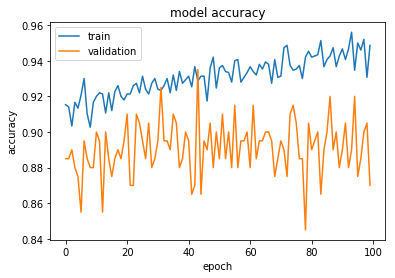

In [22]:
import matplotlib.pyplot as plt
# print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

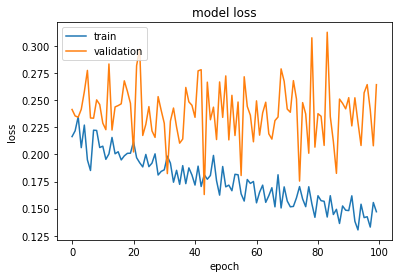

In [23]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Evaluate the model using the test dateset

In [3]:
model.load_weights('finetune_weights.h5')

In [5]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 16

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 128 images belonging to 2 classes.


In [8]:
model.evaluate_generator(test_generator, steps=int(np.ceil(128 / batch_size)), max_queue_size=10, workers=1, use_multiprocessing=False)

[0.39898041076958179, 0.8359375]